# Fault Detection Model Trial Notebook

In [1]:
import sys
import os
import torch

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

## Load data

In [2]:
from data.prep import DataPreprocessor
from data.config import DataConfig

data_config = DataConfig(run_type='train')
data_preprocessor = DataPreprocessor("fault_detection")

# Load the data
train_data, test_data, _, = data_preprocessor.get_training_data_package(data_config)

# unpack data_loaders and data_stats
train_loader = train_data[0]
test_loader = test_data[0]

train_data_stats = train_data[1]
test_data_stats = test_data[1]


'Train' type dataset selected:
No 'fs_matrix' recieved from the data. Hence, using the currently set 'fs' in data_config. Current fs:
[[48000]]


Node and signal types are set as follows:

(<node_num>) <node_type> : [<signal_types>]
---------------------------------------------
(1) gearbox   : [acc]


Total samples: 240, 
Train: 190/192 [OK=144, NOK=46, UK=0], Test: 40/48 [OK=28, NOK=12, UK=0], Val: 0/0 [OK=0, NOK=0, UK=0],
Remainder: 0 [OK=0, NOK=0, UK=0]

train_data_loader statistics:
Number of batches: 19
torch.Size([10, 1, 4000, 1])

test_data_loader statistics:
Number of batches: 4
torch.Size([10, 1, 4000, 1])

---------------------------------------------------------------------------


In [3]:
print(f"mean: {train_data_stats['mean']}, shape: {train_data_stats['mean'].shape}")
print(f"std: {train_data_stats['std']}, shape: {train_data_stats['std'].shape}")
print(f"min: {train_data_stats['min']}, shape: {train_data_stats['min'].shape}")
print(f"max: {train_data_stats['max']}, shape: {train_data_stats['max'].shape}")

mean: tensor([[[0.0694]]]), shape: torch.Size([1, 1, 1])
std: tensor([[[0.2093]]]), shape: torch.Size([1, 1, 1])
min: tensor([[[-1.7561]]]), shape: torch.Size([1, 1, 1])
max: tensor([[[2.3796]]]), shape: torch.Size([1, 1, 1])


### Process input data

In [4]:
dataiter = iter(train_loader)
data = next(dataiter)

n_nodes = data[0].shape[1]
n_timesteps = data[0].shape[2]
n_dims = data[0].shape[3]

print(f"Number of nodes: {n_nodes}")
print(f"Number of components: {n_timesteps}")  
print(f"Number of dimensions: {n_dims}")

Number of nodes: 1
Number of components: 4000
Number of dimensions: 1


## Load model

In [5]:
import sys
import os

# load model configuration
from settings.manager import AnomalyDetectorTrainManager
from fault_detection.detector import AnomalyDetector

# load model configuration
fdet_config = AnomalyDetectorTrainManager(data_config)

# load anomaly detector
anomaly_detector = AnomalyDetector(fdet_config.anom_config, fdet_config.hparams)

In [6]:
import inspect

req_run_params = inspect.signature(anomaly_detector.set_run_params).parameters.keys()
run_config = {key: value for key, value in fdet_config.__dict__.items() if key in req_run_params}

anomaly_detector.set_run_params(**run_config, data_stats=train_data_stats)

# print model info
print("Anomaly Detector Model Initialized with the following configurations:")
anomaly_detector.print_model_info()

Anomaly Detector Model Initialized with the following configurations:
Model type: IsolationForest
Number of trees in the forest: 100
Contamination: auto


## Train Model

In [7]:
from fault_detection.detector import TrainerAnomalyDetector
from torch.utils.tensorboard import SummaryWriter
from pytorch_lightning.loggers import TensorBoardLogger

n_comp, n_dims = TrainerAnomalyDetector().process_input_data(anomaly_detector, train_loader, get_data_shape=True)

# if logging enabled, save parameters and initialize TensorBoard logger
if fdet_config.is_log:
    train_log_path = fdet_config.get_train_log_path(n_comp, n_dims)
    fdet_config.save_params()
    train_logger = SummaryWriter(log_dir=train_log_path)
    formatted_params = "\n".join([f"{key}: {value}" for key, value in fdet_config.__dict__.items()])
    train_logger.add_text(os.path.basename(train_log_path), formatted_params)

    sanitized_dict = {
    key: (value if isinstance(value, (int, float, bool, torch.Tensor)) else str(value))
    for key, value in fdet_config.__dict__.items()
    }

else:
    train_logger = None

# train the anomaly detector
trainer = TrainerAnomalyDetector(logger=train_logger)
model = trainer.fit(anomaly_detector, train_loader)

'Version 1' already exists in the log path 
'c:\Aryan_Savant\Thesis_Projects\my_work\AFD_thesis\fault_detection\logs\bearing\cwru\scene_1\train\(gearbox)\IF\(g
earbox)-IF_fdet_1'.

Next model number folder will be: (gearbox)-IF_fdet_5

Model parameters saved to 
c:\Aryan_Savant\Thesis_Projects\my_work\AFD_thesis\fault_detection\logs\bearing\cwru\scene_1\train\(gearbox)\IF\(ge
arbox)-IF_fdet_5.


No seperate features extracted, so using components as features: [comp0_dim0, comp1_dim0, comp2_dim0, comp3_dim0...comp3996_dim0, comp3997_dim0, comp3998_dim0, comp3999_dim0]

Fitting anomaly detection model...

Model fitted successfully in 2.38 seconds

Dataframe is as follows:
     comp0_dim0  comp1_dim0  comp2_dim0  comp3_dim0  comp4_dim0  comp5_dim0  \
0      0.538446    0.534712    0.517659    0.497276    0.481231    0.464077   
1      0.437232    0.438342    0.432894    0.430473    0.437383    0.444496   
2      0.438345    0.425933    0.427548    0.443088    0.460848    0.485368   
3      0.379919    0.369728    0.368113    0.374470    0.392028    0.416145   
4      0.429212    0.422100    0.418316    0.417156    0.422352    0.427497   
..          ...         ...         ...         ...         ...         ...   
185    0.403537    0.405756    0.417408    0.425530    0.427093    0.421898   
186    0.428455    0.415946    0.416248    0.426589    0.437484    0.441469   
187    0


<<<<<<<<<<<< PAIR PLOT >>>>>>>>>>>>

> Creating pair plot for (gearbox)-IF_fdet_5 / train...


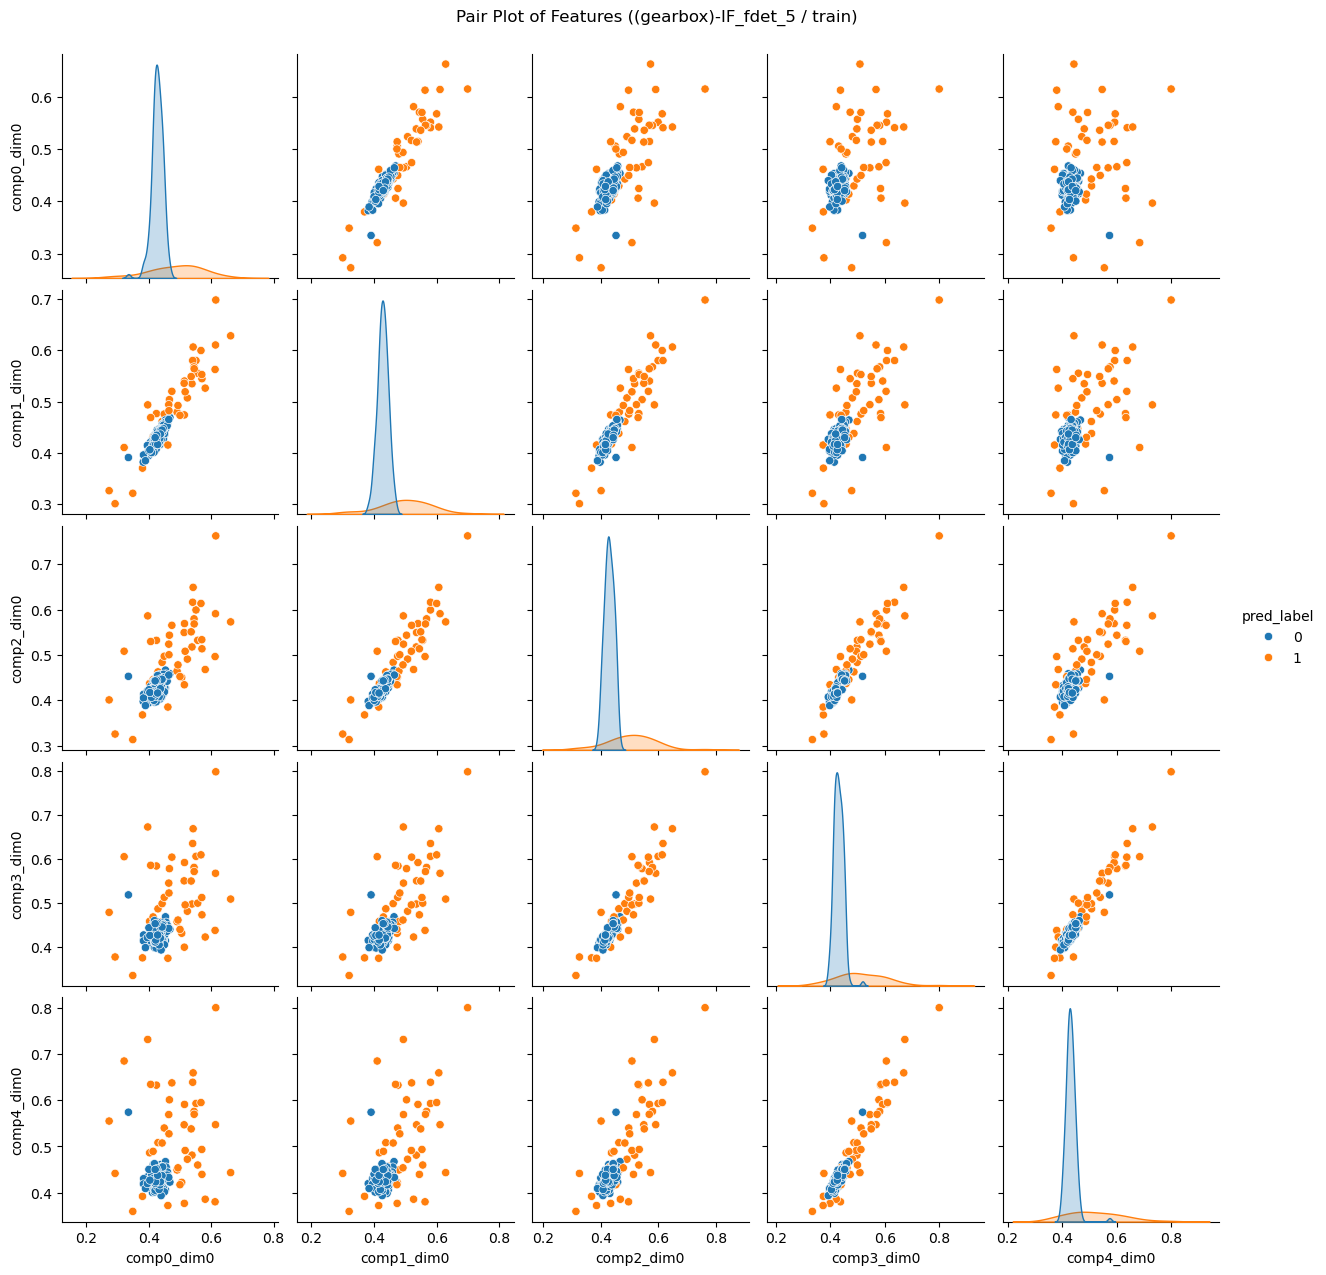


Pair plot logged at c:\Aryan_Savant\Thesis_Projects\my_work\AFD_thesis\fault_detection\logs\bearing\cwru\scene_1\train\(gearbox)\IF\(gearbox)-IF_fdet_5



In [8]:
trainer.pair_plot()


Creating confusion matrix for OneClassSVM / train...

Confusion matrix not logged as logging is disabled.


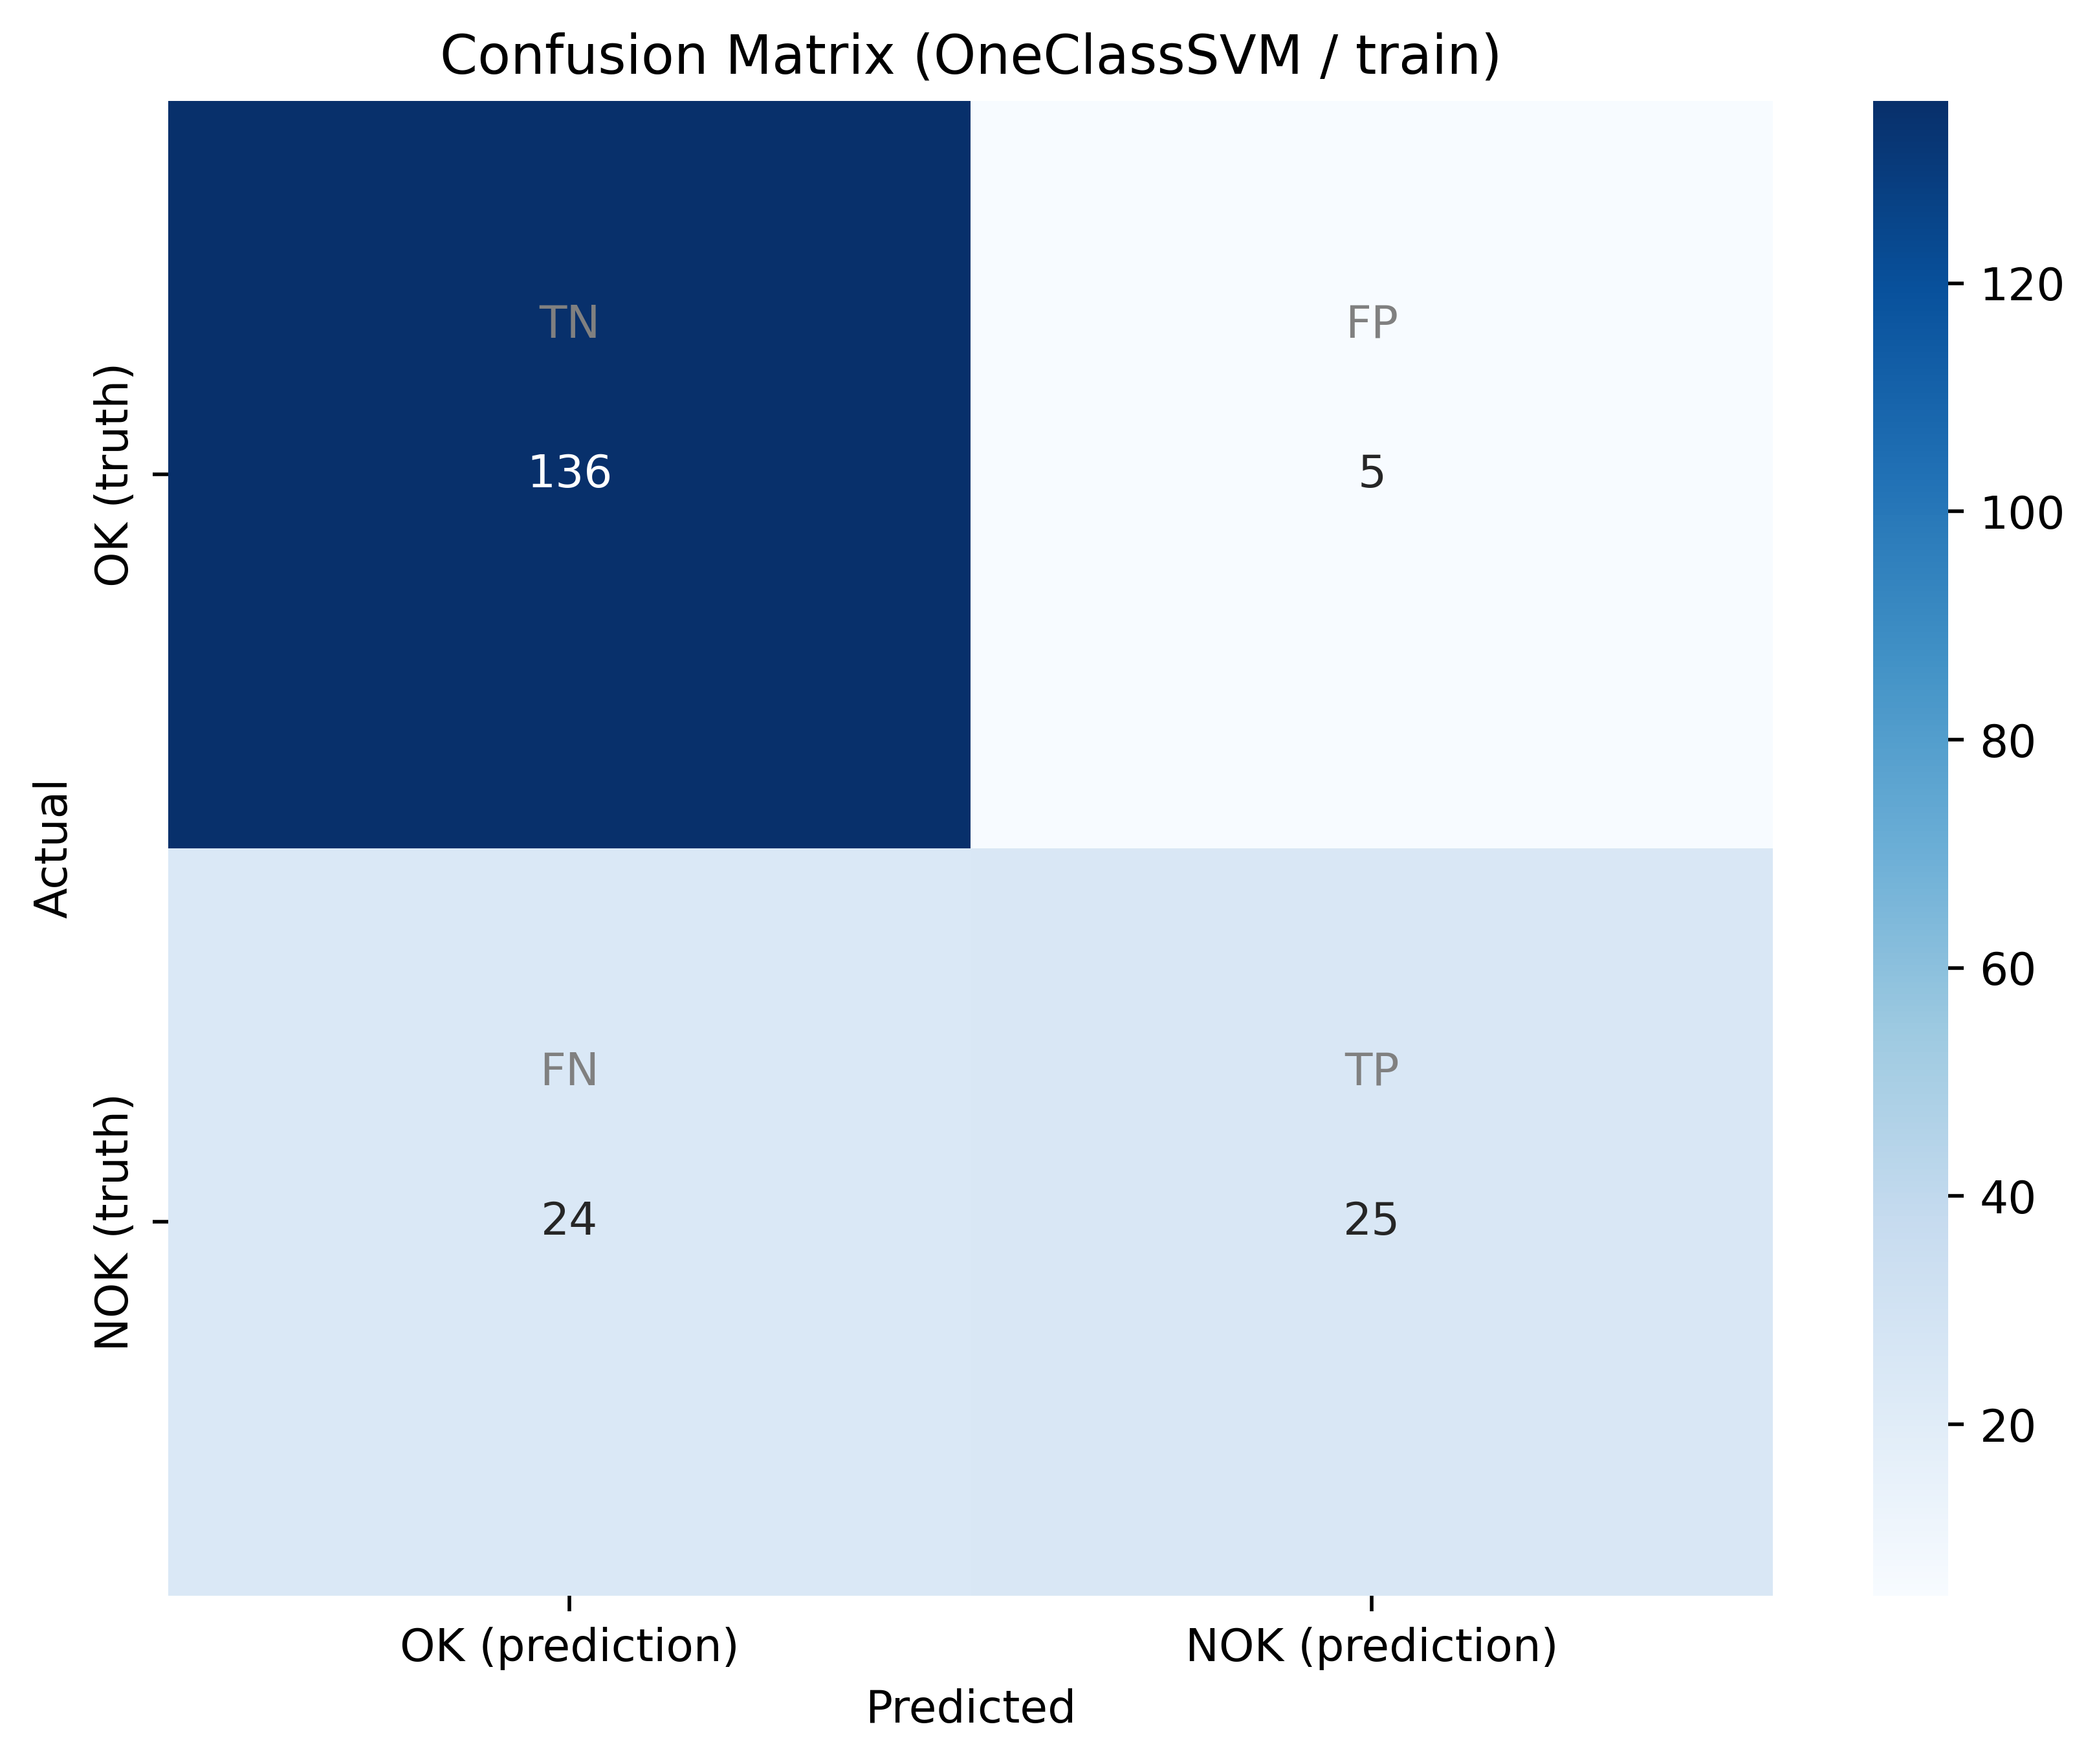

In [9]:
trainer.confusion_matrix()


Creating ROC curve for OneClassSVM / train...

ROC curve not logged as logging is disabled.


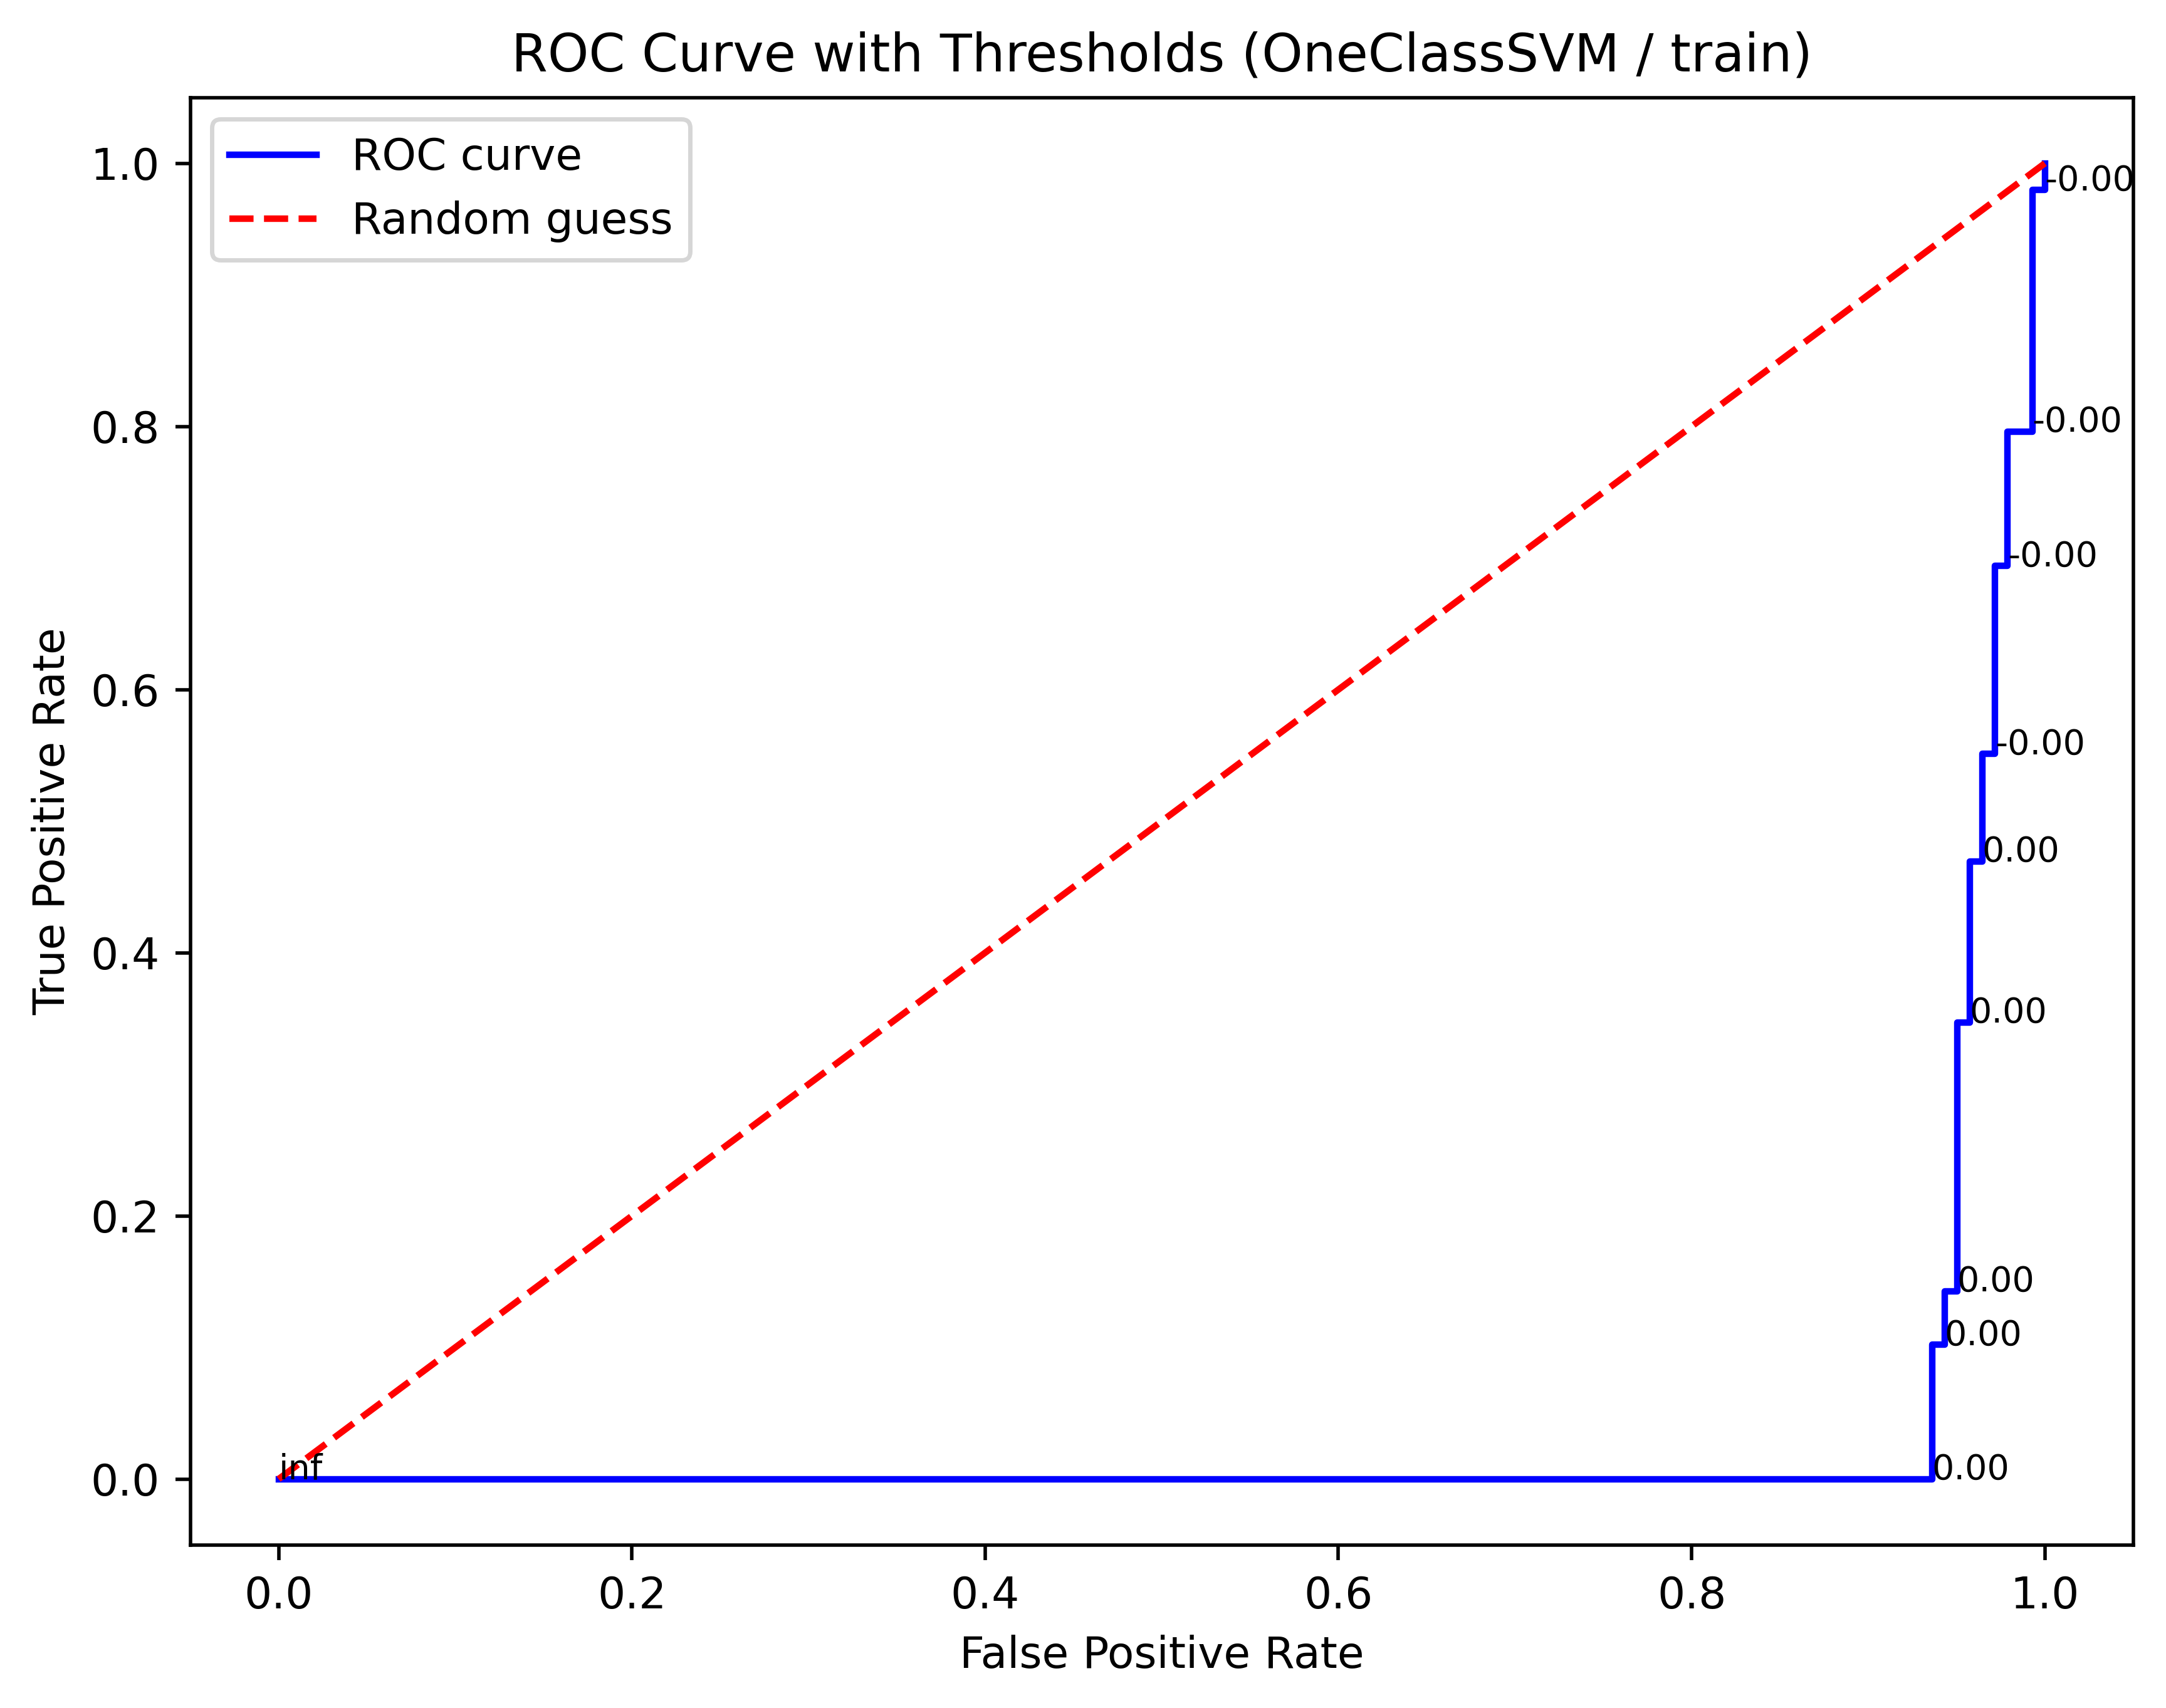

In [10]:
trainer.roc_curve()


Creating anomaly score distribution plot for OneClassSVM / train...

Total OK samples (from given_label) : 141
---------- Samples in OK bins ----------
Bin 0 (-0.00038, 0.00007): [25, 52, 58, 87, 88, 115]
Bin 1 (0.00007, 0.00052): [11, 45, 65]
Bin 4 (0.00142, 0.00187): [14, 93]
Bin 6 (0.00232, 0.00277): [130, 171]
Bin 8 (0.00322, 0.00367): [31]
Bin 9 (0.00367, 0.00412): [34]
Bin 10 (0.00412, 0.00457): [104]
Bin 11 (0.00457, 0.00502): [118, 143]
Bin 13 (0.00547, 0.00592): [153]
Bin 14 (0.00592, 0.00637): [76]
Bin 15 (0.00637, 0.00682): [113, 167]
Bin 16 (0.00682, 0.00727): [99, 147, 164]
Bin 17 (0.00727, 0.00772): [0, 181]
Bin 18 (0.00772, 0.00818): [23, 37, 69, 72, 96, 154]
Bin 19 (0.00818, 0.00863): [47]
Bin 20 (0.00863, 0.00908): [78, 106]
Bin 22 (0.00953, 0.00998): [1, 15, 91, 165, 185]
Bin 23 (0.00998, 0.01043): [92, 162]
Bin 24 (0.01043, 0.01088): [56, 183, 188]
Bin 25 (0.01088, 0.01133): [50, 117]
Bin 27 (0.01178, 0.01223): [39, 49]
Bin 28 (0.01223, 0.01268): [38, 135, 160]
Bin 

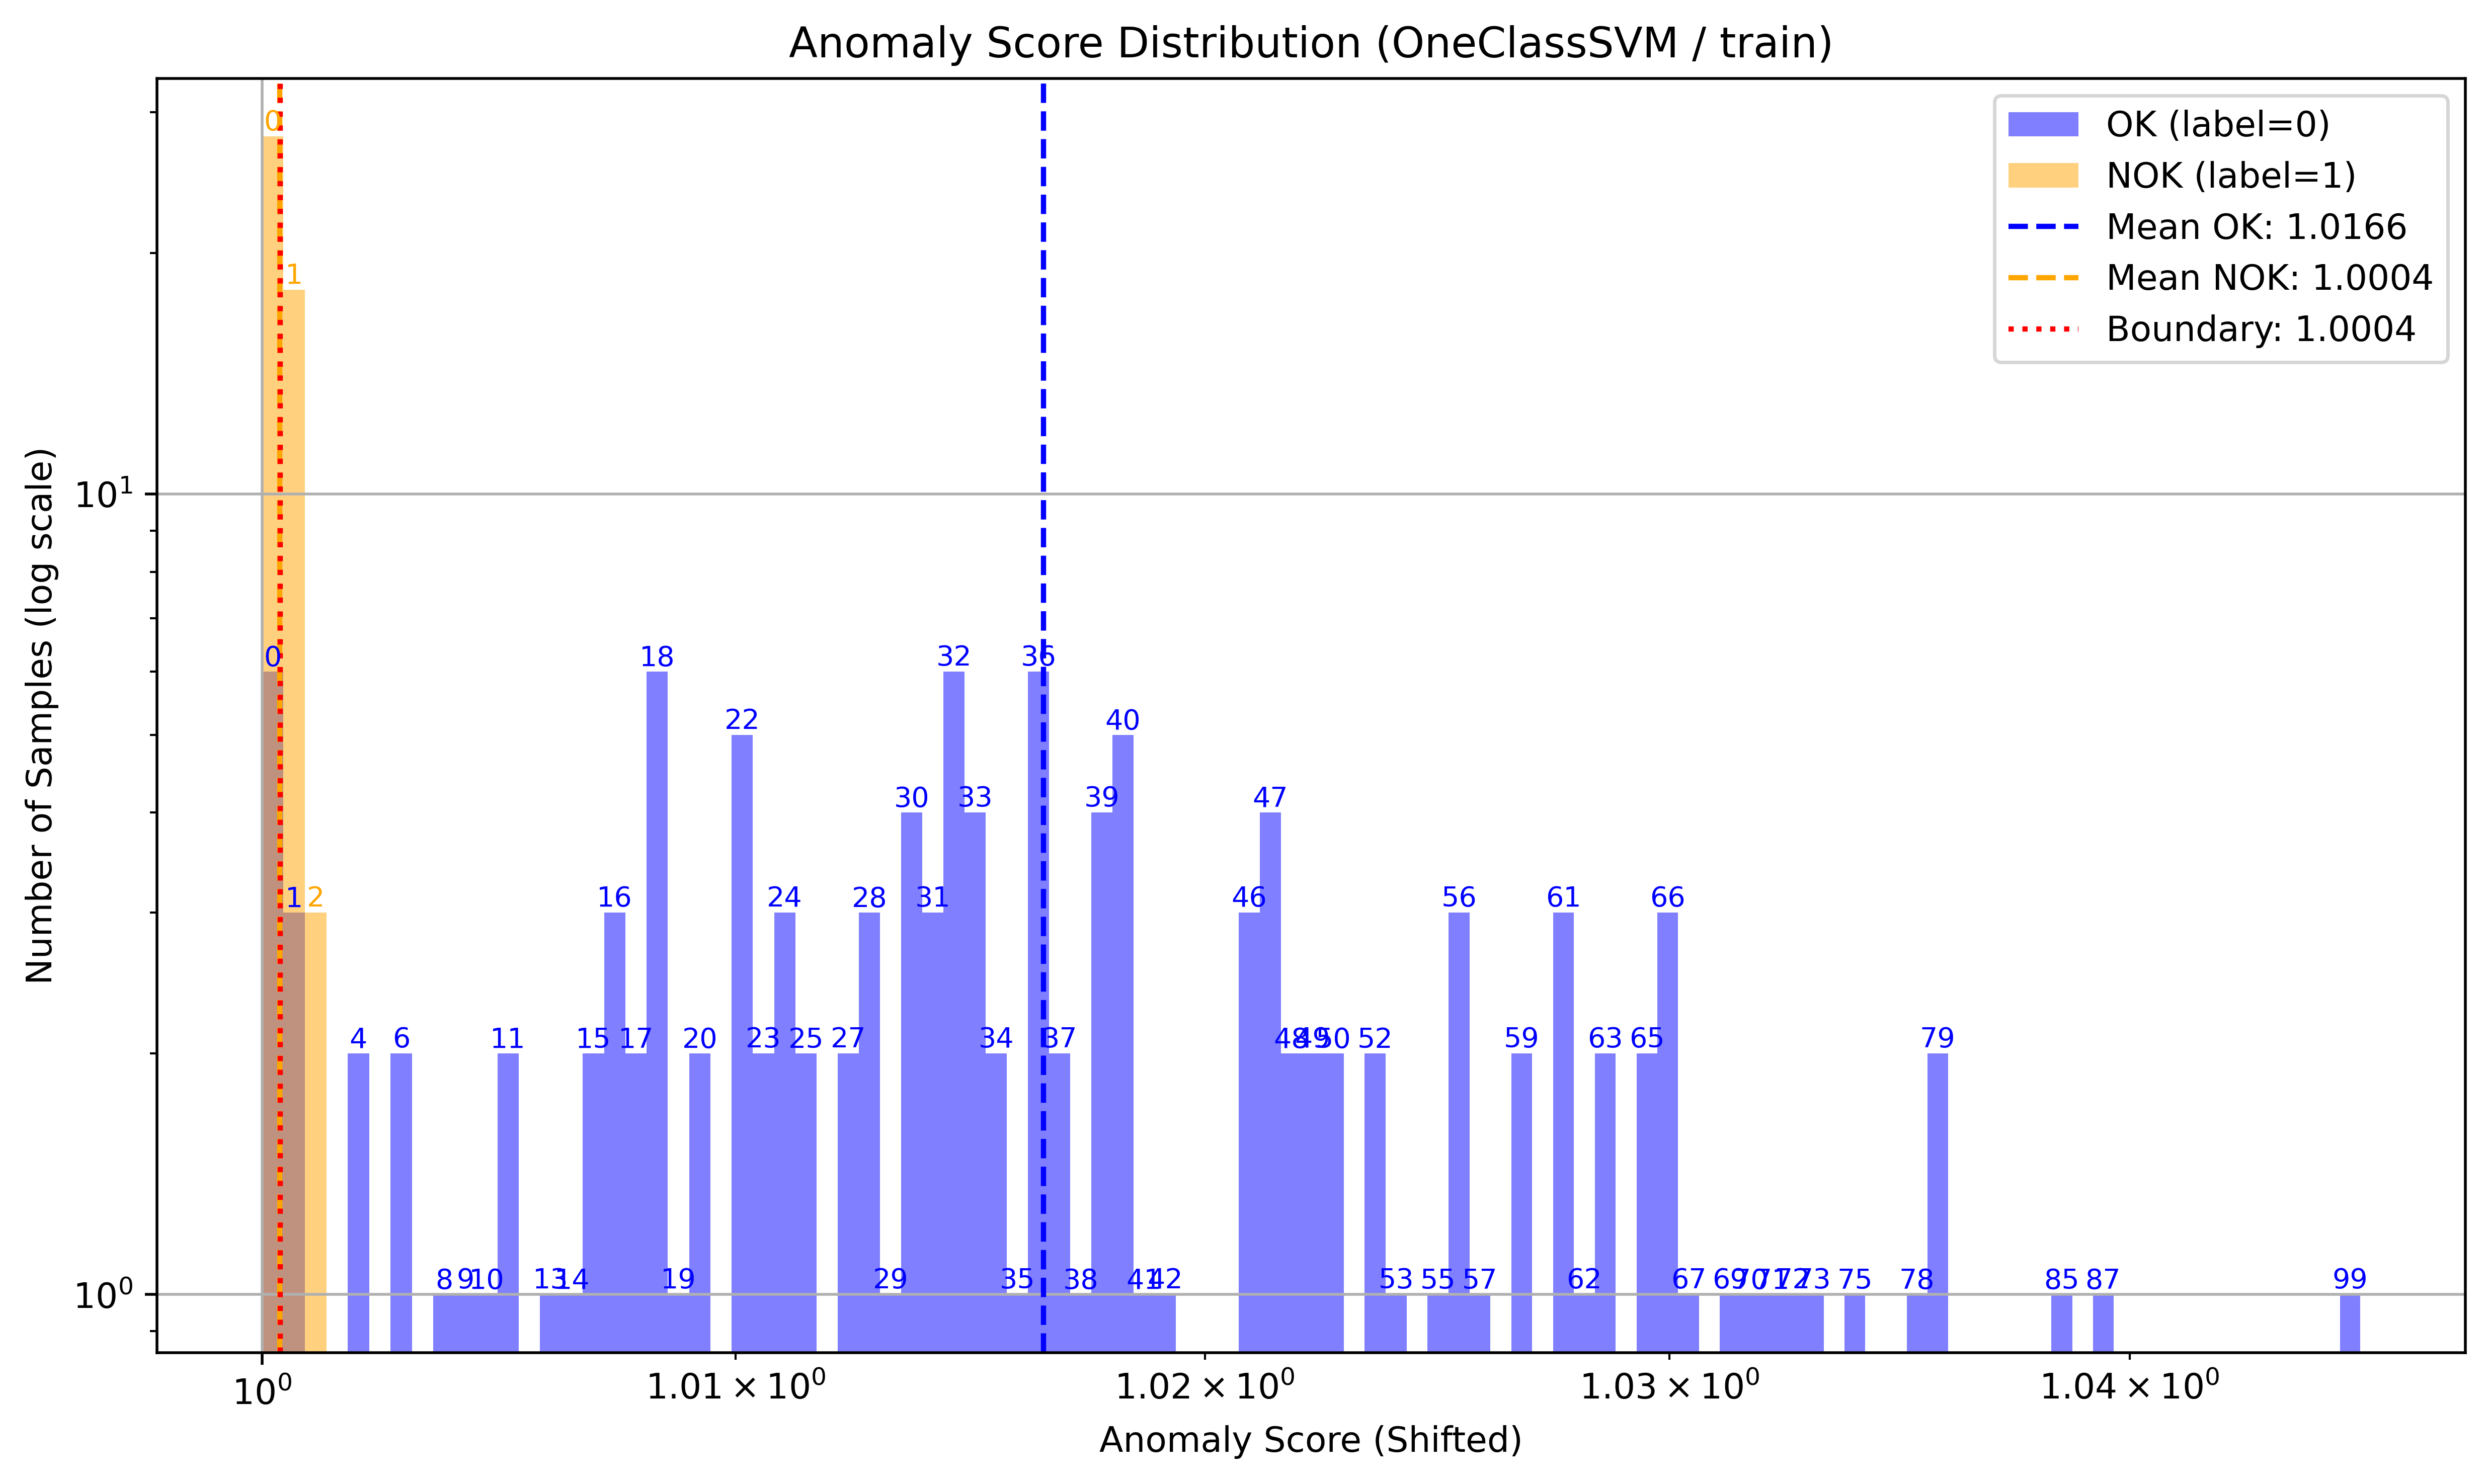

In [11]:
trainer.anomaly_score_dist(is_pred=False ,bins=100)


Creating prediction plot for OneClassSVM / train...

Prediction plot not logged as logging is disabled.


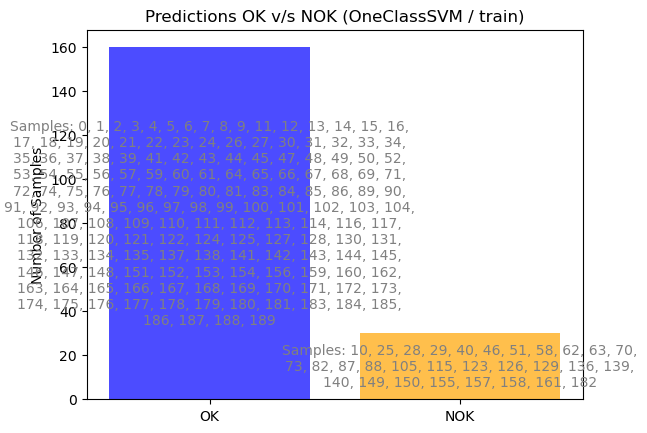

In [12]:
trainer.pred_plot()

### Test model

In [1]:
import sys
import os
import torch

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

In [ ]:
from settings.manager import get_model_pickle_path

# load trained model
trained_anomaly_detector = AnomalyDetector.load_from_pickle(get_model_pickle_path("C:\\Aryan_Savant\\Thesis_Projects\\my_work\\AFD_thesis\\fault_detection\\logs\\bearing\\cwru\\scene_1\\train\(gearbox)\\1SVM\\(gearbox)-1SVM_fdet_5"))

# update its data stats
trained_anomaly_detector.data_stats = test_data_stats

# initialize logger for testing
if fdet_config.is_log:
    test_logger = SummaryWriter(log_dir=fdet_config.get_test_log_path())
else:
    test_logger = None

# initialize tester
tester = TrainerAnomalyDetector(logger=test_logger)
tester.test(trained_anomaly_detector, test_loader)


Test accuracy: 0.96


## Custom Test

In [8]:
# new data
data_config.set_custom_test_dataset()

custom_test_data = data_preprocessor.get_custom_data(data_config)

custom_test_loader = custom_test_data[0]
custom_test_data_stats = custom_test_data[1]

Total samples: 12168, Desired samples: 7300, Remainder samples: 4868


In [9]:
from settings.manager import AnomalyDetectorPredictManager
import inspect
pred_config = AnomalyDetectorPredictManager(data_config)

trained_anomaly_detector = AnomalyDetector.load_from_pickle(pred_config.ckpt_path)

anomaly_detector.data_stats = custom_test_data_stats

In [10]:
from detector import TrainerAnomalyDetector
from torch.utils.tensorboard import SummaryWriter

custom_test_log_path = pred_config.get_custom_test_log_path()

# initialize logger
if fdet_config.is_log:
    pred_config.save_custom_test_params()
    logger = SummaryWriter(custom_test_log_path)
else:
    logger = None

# initialize trainer
tester = TrainerAnomalyDetector(logger=logger)
tester.test(trained_anomaly_detector, custom_test_loader)

custom_test number 1 for already exists for (gearbox)_fault_detector_7 in the log path 
'c:\Aryan_Savant\Thesis_Projects\my_work\AFD_thesis\fault_detection\logs\bearing\cwru\scene_1\custom_test\(gearbox)
\(gearbox)_fault_detector_7\(gearbox)_custom_test_1'.

Overwrote version 1 from the log path 
c:\Aryan_Savant\Thesis_Projects\my_work\AFD_thesis\fault_detection\logs\bearing\cwru\scene_1\custom_test\(gearbox)\
(gearbox)_fault_detector_7\(gearbox)_custom_test_1.

Custom test parameters saved to 
c:\Aryan_Savant\Thesis_Projects\my_work\AFD_thesis\fault_detection\logs\bearing\cwru\scene_1\custom_test\(gearbox)\
(gearbox)_fault_detector_7\(gearbox)_custom_test_1.

Test accuracy: 0.99


## Other stuff

In [1]:
import sys
import os
import torch

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

In [2]:
import os
from data.config import DataConfig
from settings.manager import AnomalyDetectorTrainManager

data_config = DataConfig(run_type="custom_test")
fdet_config = AnomalyDetectorTrainManager(data_config)

log_path = fdet_config.get_train_log_path(600, 1)
print(log_path)

if log_path is not None:
    os.makedirs(log_path, exist_ok=True)

fdet_config.save_params()

'Version 1' already exists in the log path 
'c:\Aryan_Savant\Thesis_Projects\my_work\AFD_thesis\fault_detection\logs\bearing\cwru\scene_1\train\(1_gearbox)\(1_
gearbox)_fault_detector_1'.

Next model number folder will be: (1_gearbox)_fault_detector_10

c:\Aryan_Savant\Thesis_Projects\my_work\AFD_thesis\fault_detection\logs\bearing\cwru\scene_1\train\(1_gearbox)\(1_gearbox)_fault_detector_10


Model parameters saved to 
c:\Aryan_Savant\Thesis_Projects\my_work\AFD_thesis\fault_detection\logs\bearing\cwru\scene_1\train\(1_gearbox)\(1_g
earbox)_fault_detector_10.

predict

In [3]:
import os
from data.config import DataConfig
from fault_detection.config import PredictAnomalyDetectorConfig

fdet_config = PredictAnomalyDetectorConfig()

data_config = DataConfig()
data_config.set_predict_dataset()

log_path = fdet_config.get_predict_log_path()
print(log_path)

if log_path is not None:
    os.makedirs(log_path, exist_ok=True)

fdet_config.save_predict_params()

c:\AFD\fault_detection\logs\bearing\cwru\scene_1\predict\(gearbox)\(gearbox)_fault_detector_1\(gearbox)_predict_1
Predict parameters saved to c:\AFD\fault_detection\logs\bearing\cwru\scene_1\predict\(gearbox)\(gearbox)_fault_detector_1\(gearbox)_predict_1.


test

In [2]:
import os
from data.config import DataConfig
from fault_detection.config import PredictAnomalyDetectorConfig

fdet_config = PredictAnomalyDetectorConfig()

data_config = DataConfig()
data_config.set_custom_test_dataset()

log_path = fdet_config.get_custom_test_log_path()
print(log_path)

if log_path is not None:
    os.makedirs(log_path, exist_ok=True)

fdet_config.save_custom_test_params()


custom_test number 1 for already exists for (gearbox)_fault_detector_1 in the log path 'c:\AFD\fault_detection\logs\bearing\cwru\scene_1\custom_test\(gearbox)\(gearbox)_fault_detector_1\(gearbox)_custom_test_1'.
Removed version 1 from the log path c:\AFD\fault_detection\logs\bearing\cwru\scene_1\custom_test\(gearbox)\(gearbox)_fault_detector_1\(gearbox)_custom_test_1.
c:\AFD\fault_detection\logs\bearing\cwru\scene_1\custom_test\(gearbox)\(gearbox)_fault_detector_1\(gearbox)_custom_test_1
Custom test parameters saved to c:\AFD\fault_detection\logs\bearing\cwru\scene_1\custom_test\(gearbox)\(gearbox)_fault_detector_1\(gearbox)_custom_test_1.


In [3]:
from fault_detection.config import SelectFaultDetectionModel

model_selector = SelectFaultDetectionModel(run_type="train")
                                           
model_selector.select_model_and_params()

bearing
└── cwru
    └── scene_1 (trained models)
        ├── <node_name>
        └── (gearbox)
            ├── <ds_type>
            └── healthy_unhealthy
                ├── <ds_subtype>
                └── 0_N[OG, gau_m=0.1s=0.2, gau_m=0.2s=0.3] + 0_B-007[gau_m=0.0s=0.1, gau_m=0.1s=0.2] + 0_B-021[OG]
                    ├── <model>
                    └── [anom] IF
                        ├── <ds_stats>
                        └── T500 [acc]
                            ├── <domain>
                            └── time
                                ├── <fex_type>
                                ├── (anom) [first_n_modes]
                                │   ├── <shape_compatibility>
                                │   └── anom (comps = 500)
                                │       ├── <versions>
                                │       └── (gearbox)_fault_detector_1 (v1) [0]
                                └── (anom) [no_fex]
                                    ├── <shape_compatibility>
                                    └── anom (comps = 500)
                                        ├── <versions>
                                        └── (gearbox)_fault_detector_2 (v1) [1]


Available version paths:
0: c:\AFD\fault_detection\logs\bearing\cwru\scene_1\train\(gearbox)\(gearbox)_fault_detector_1
1: c:\AFD\fault_detection\logs\bearing\cwru\scene_1\train\(gearbox)\(gearbox)_fault_detector_2


ValueError: invalid literal for int() with base 10: ''